In [1]:
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

# Get data

In [2]:
zip_path = tf.keras.utils.get_file(origin='https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip', fname='jena_climate_2009_2016.csv.zip', extract=True)
csv_path, _ = os.path.splitext(zip_path)

In [3]:
df = pd.read_csv(csv_path)
# will use hourly predictions, so sample from hour, i.e. from index 5 and take every 6th record
df = df[5::6]

date_time = pd.to_datetime(df.pop('Date Time'), format='%d.%m.%Y %H:%M:%S')

In [4]:
df.head()

p (mbar)  T (degC)  Tpot (K)  Tdew (degC)  rh (%)  VPmax (mbar)  \
5     996.50     -8.05    265.38        -8.78    94.4          3.33   
11    996.62     -8.88    264.54        -9.77    93.2          3.12   
17    996.84     -8.81    264.59        -9.66    93.5          3.13   
23    996.99     -9.05    264.34       -10.02    92.6          3.07   
29    997.46     -9.63    263.72       -10.65    92.2          2.94   

    VPact (mbar)  VPdef (mbar)  sh (g/kg)  H2OC (mmol/mol)  rho (g/m**3)  \
5           3.14          0.19       1.96             3.15       1307.86   
11          2.90          0.21       1.81             2.91       1312.25   
17          2.93          0.20       1.83             2.94       1312.18   
23          2.85          0.23       1.78             2.85       1313.61   
29          2.71          0.23       1.69             2.71       1317.19   

    wv (m/s)  max. wv (m/s)  wd (deg)  
5       0.21           0.63     192.7  
11      0.25           0.63     190.3  
17      0.18           0.63     167.2  
23      0.10           0.38     240.0  
29      0.40           0.88     157.0

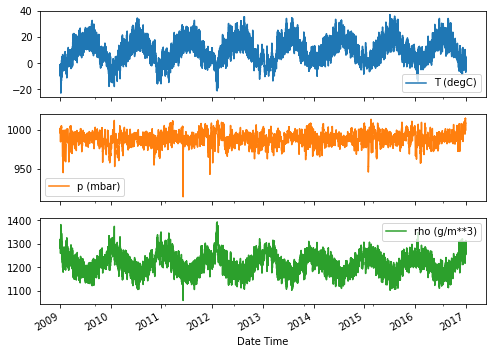

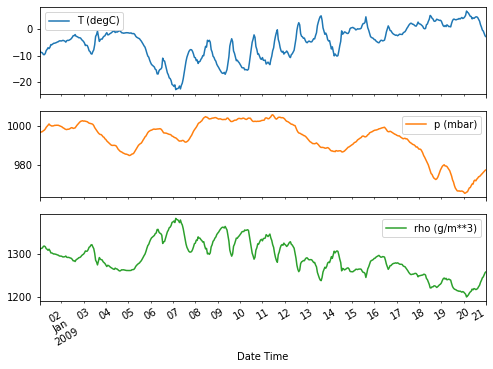

In [5]:
plot_cols = ['T (degC)', 'p (mbar)', 'rho (g/m**3)']

plot_features = df[plot_cols]
plot_features.index = date_time
_ = plot_features.plot(subplots=True)

plot_features = df[plot_cols][:480]
plot_features.index = date_time[:480]
_ = plot_features.plot(subplots=True)

### clean data

In [6]:
df.describe().transpose()

count         mean        std      min      25%      50%  \
p (mbar)         70091.0   989.212842   8.358886   913.60   984.20   989.57   
T (degC)         70091.0     9.450482   8.423384   -22.76     3.35     9.41   
Tpot (K)         70091.0   283.493086   8.504424   250.85   277.44   283.46   
Tdew (degC)      70091.0     4.956471   6.730081   -24.80     0.24     5.21   
rh (%)           70091.0    76.009788  16.474920    13.88    65.21    79.30   
VPmax (mbar)     70091.0    13.576576   7.739883     0.97     7.77    11.82   
VPact (mbar)     70091.0     9.533968   4.183658     0.81     6.22     8.86   
VPdef (mbar)     70091.0     4.042536   4.898549     0.00     0.87     2.19   
sh (g/kg)        70091.0     6.022560   2.655812     0.51     3.92     5.59   
H2OC (mmol/mol)  70091.0     9.640437   4.234862     0.81     6.29     8.96   
rho (g/m**3)     70091.0  1216.061232  39.974263  1059.45  1187.47  1213.80   
wv (m/s)         70091.0     1.702567  65.447512 -9999.00     0.99     1.76   
max. wv (m/s)    70091.0     2.963041  75.597657 -9999.00     1.76     2.98   
wd (deg)         70091.0   174.789095  86.619431     0.00   125.30   198.10   

                      75%      max  
p (mbar)          994.720  1015.29  
T (degC)           15.480    37.28  
Tpot (K)          289.530   311.21  
Tdew (degC)        10.080    23.06  
rh (%)             89.400   100.00  
VPmax (mbar)       17.610    63.77  
VPact (mbar)       12.360    28.25  
VPdef (mbar)        5.300    46.01  
sh (g/kg)           7.800    18.07  
H2OC (mmol/mol)    12.490    28.74  
rho (g/m**3)     1242.765  1393.54  
wv (m/s)            2.860    14.01  
max. wv (m/s)       4.740    23.50  
wd (deg)          234.000   360.00

In [7]:
# change wind velocity min from -9999 to 0, because there is a wind direction feature, so velocity should be positive
wv = df['wv (m/s)']
bad_wv = wv == -9999.0
wv[bad_wv] = 0.0

max_wv = df['max. wv (m/s)']
bad_max_wv = max_wv == -9999.0
max_wv[bad_max_wv] = 0.0

df['wv (m/s)'].min()

0.0

### feature engineering

Text(0, 0.5, 'Wind velocity [m/s]')

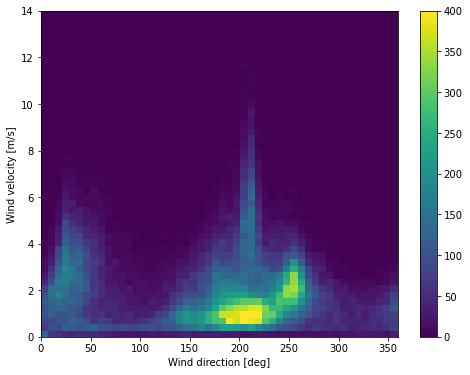

In [8]:
# plot the current distribution of wind data
plt.hist2d(df['wd (deg)'], df['wv (m/s)'], bins=(50, 50), vmax=400)
plt.colorbar()
plt.xlabel('Wind direction [deg]')
plt.ylabel('Wind velocity [m/s]')

In [9]:
# convert wind direction and velocity into wind vector, because angles do not make good model features
wv = df.pop('wv (m/s)')
max_wv = df.pop('max. wv (m/s)')

# convert to radians
wd_rad = df.pop('wd (deg)') * np.pi / 180

# calculate wind vector x and y
df['Wx'] = wv * np.cos(wd_rad)
df['Wy'] = wv * np.sin(wd_rad)

# calculate max wind vector x and y
df['max Wx'] = max_wv * np.cos(wd_rad)
df['max Wy'] = max_wv * np.sin(wd_rad)

(-11.305513973134667, 8.24469928549079, -8.27438540335515, 7.7338312955467785)

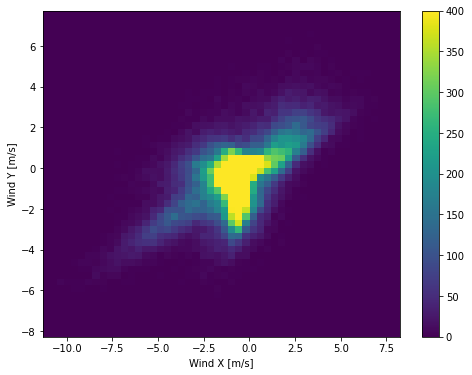

In [10]:
plt.hist2d(df['Wx'], df['Wy'], bins=(50, 50), vmax=400)
plt.colorbar()
plt.xlabel('Wind X [m/s]')
plt.ylabel('Wind Y [m/s]')
ax = plt.gca()
ax.axis('tight')

In [11]:
# convert data_time column from strings to seconds
timestamp_s = date_time.map(datetime.datetime.timestamp)

In [12]:
# convert seconds to time of day and time of year
day = 24 * 60 * 60
year = 365.2425 * day

df['Day sin'] = np.sin(timestamp_s * (2 * np.pi / day))
df['Day cos'] = np.cos(timestamp_s * (2 * np.pi / day))
df['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year))
df['Year cos'] = np.cos(timestamp_s * (2 * np.pi / year))

Text(0.5, 1.0, 'Time of day signal')

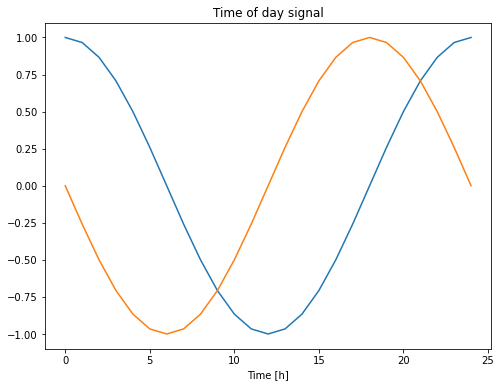

In [13]:
plt.plot(np.array(df['Day sin'])[:25])
plt.plot(np.array(df['Day cos'])[:25])
plt.xlabel('Time [h]')
plt.title('Time of day signal')

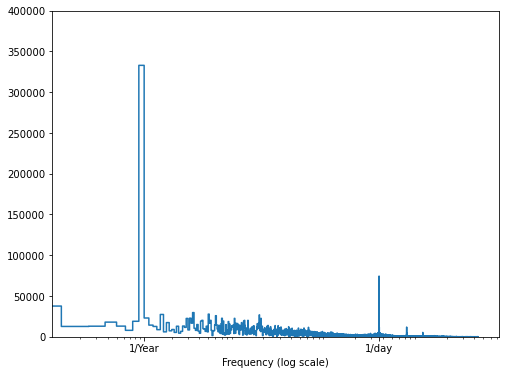

In [14]:
fft = tf.signal.rfft(df['T (degC)'])
f_per_dataset = np.arange(0, len(fft))

n_samples_h = len(df['T (degC)'])
hours_per_year = 24*365.2524
years_per_dataset = n_samples_h/(hours_per_year)

f_per_year = f_per_dataset/years_per_dataset
plt.step(f_per_year, np.abs(fft))
plt.xscale('log')
plt.ylim(0, 400000)
plt.xlim([0.1, max(plt.xlim())])
plt.xticks([1, 365.2524], labels=['1/Year', '1/day'])
_ = plt.xlabel('Frequency (log scale)')

In [15]:
# do not shuffle data before splitting, becase
# keeps consectuive time data
# validation and test data follows train data, in a time manner
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

num_features = df.shape[1]

### normalize data

In [16]:
# only normalize using the training set's mean and std
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

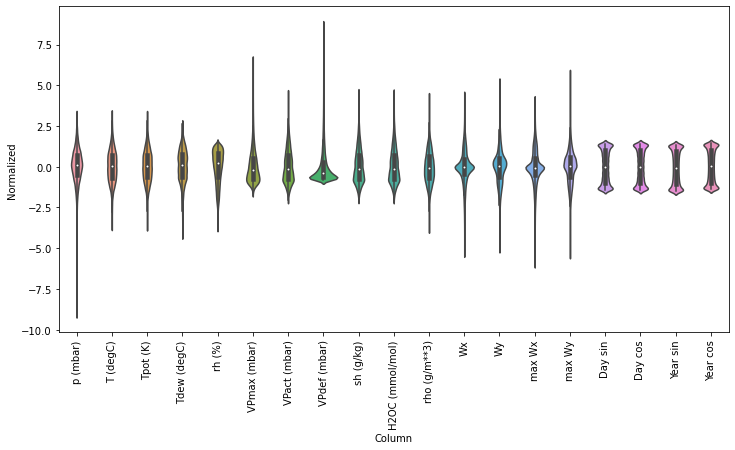

In [17]:
df_std = (df - train_mean) / train_std
df_std = df_std.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(df.keys(), rotation=90)

# Data windowing

### index and offset

In [18]:
class WindowGenerator():
    def __init__(self, input_width, label_width, shift, train_df=train_df, val_df=val_df, test_df=test_df, label_columns=None):
        # store raw data
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df

        # label column indices
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in enumerate(label_columns)}
        self.column_indices = {name: i for i, name in enumerate(train_df.columns)}

        # window parameters
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift

        self.total_window_size = input_width + shift

        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]

        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

    def __repr__(self):
        return '\n'.join([
            f'Total window size: {self.total_window_size}',
            f'Input indices: {self.input_indices}',
            f'Label indices: {self.label_indices}',
            f'Label column name(s): {self.label_columns}'])

In [19]:
# create sample windows
# given 24h of history, predict one instance 24h into the future
w1 = WindowGenerator(input_width=24, label_width=1, shift=24, label_columns=['T (degC)'])
w1

Total window size: 48
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [47]
Label column name(s): ['T (degC)']

In [20]:
# given 6h of history, predict one instance 1h into the future
w2 = WindowGenerator(input_width=6, label_width=1, shift=1, label_columns=['T (degC)'])
w2

Total window size: 7
Input indices: [0 1 2 3 4 5]
Label indices: [6]
Label column name(s): ['T (degC)']

### split

In [21]:
# given a list of consecutive inputs, convert to a window of inputs and a window of labels
def split_window(self, features):
    inputs = features[:, self.input_slice, :]
    labels = features[:, self.labels_slice, :]
    if self.label_columns is not None:
        labels = tf.stack([labels[:, :, self.column_indices[name]] for name in self.label_columns], axis=-1)

    # slicing doesn't preversve static shape, so need to set manually
    inputs.set_shape([None, self.input_width, None])
    labels.set_shape([None, self.label_width, None])

    return inputs, labels

WindowGenerator.split_window = split_window

In [22]:
# stack 3 slices, the length of total window
example_window = tf.stack([np.array(train_df[:w2.total_window_size]), np.array(train_df[100:100+w2.total_window_size]), np.array(train_df[200:200+w2.total_window_size])])

example_inputs, example_labels = w2.split_window(example_window)

print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'labels shape: {example_labels.shape}')

All shapes are: (batch, time, features)
Window shape: (3, 7, 19)
Inputs shape: (3, 6, 19)
labels shape: (3, 1, 1)


### plot

In [23]:
w2.example = example_inputs, example_labels

In [24]:
def plot(self, model=None, plot_col='T (degC)', max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(3, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Time [h]')

WindowGenerator.plot = plot

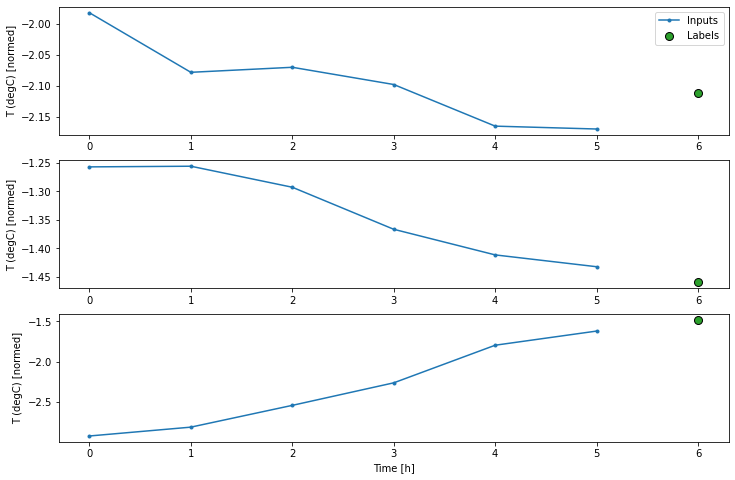

In [25]:
w2.plot()

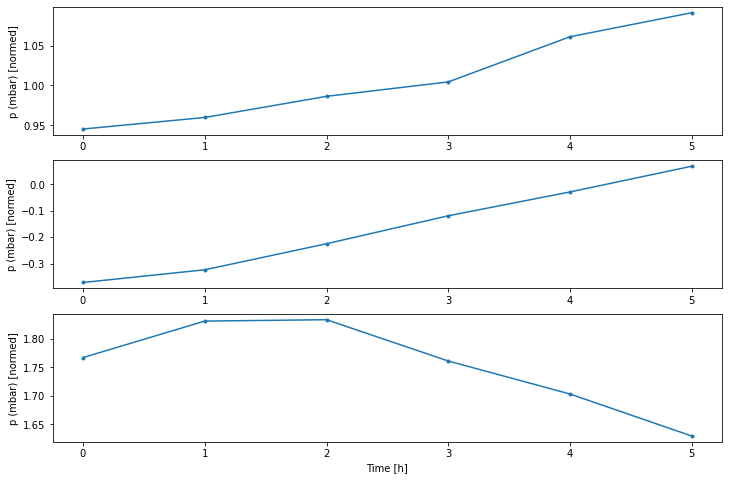

In [26]:
# can also plot other columns
w2.plot(plot_col='p (mbar)')

### create dataset

In [27]:
def make_dataset(self, data):
    data = np.array(data, dtype=np.float32)
    ds = tf.keras.preprocessing.timeseries_dataset_from_array(
        data=data,
        targets=None,
        sequence_length=self.total_window_size,
        sequence_stride=1,
        shuffle=True,
        batch_size=32
    )

    ds = ds.map(self.split_window)

    return ds

WindowGenerator.make_dataset = make_dataset

In [28]:
# methods to access dataset
@property
def train(self):
    return self.make_dataset(self.train_df)

@property
def val(self):
    return self.make_dataset(self.val_df)

@property
def test(self):
    return self.make_dataset(self.test_df)

@property
def example(self):
    # get and cache an example batch of data for plotting
    result = getattr(self, '_example', None)
    if result is None:
        # no example batch, so get one from train set
        result = next(iter(self.train))
        # cache it
        self._example = result
    return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

In [29]:
# each element is (inputs, label)
w2.train.element_spec

(TensorSpec(shape=(None, 6, 19), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 1, 1), dtype=tf.float32, name=None))

In [30]:
# check dataset
for example_inputs, example_labels in w2.train.take(1):
    print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
    print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 6, 19)
Labels shape (batch, time, features): (32, 1, 1)


# Single step models

In [31]:
# given 1h history, predict 1h into the future
single_step_window = WindowGenerator(input_width=1, label_width=1, shift=1, label_columns=['T (degC)'])
single_step_window

Total window size: 2
Input indices: [0]
Label indices: [1]
Label column name(s): ['T (degC)']

In [32]:
for example_inputs, example_labels in single_step_window.train.take(1):
    print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
    print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 1, 19)
Labels shape (batch, time, features): (32, 1, 1)


### baseline

In [33]:
# baseline model just use current temperature as prediction
class Baseline(tf.keras.Model):
    def __init__(self, label_index=None):
        super().__init__()
        self.label_index = label_index

    def call(self, inputs):
        if self.label_index is None:
            return inputs
        result = inputs[:, :, self.label_index]
        return result[:, :, tf.newaxis]

In [34]:
# evaluate model
baseline = Baseline(label_index=column_indices['T (degC)'])

baseline.compile(loss=tf.losses.MeanSquaredError(), metrics=[tf.metrics.MeanAbsoluteError()])

val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(single_step_window.val)
performance['Baseline'] = baseline.evaluate(single_step_window.test, verbose=0)

439/439 [==============================] - 1s 2ms/step - loss: 0.0128 - mean_absolute_error: 0.0785


In [35]:
# give 1h of history (x24), predict 1h into the future (x24)
wide_window = WindowGenerator(input_width=24, label_width=24, shift=1, label_columns=['T (degC)'])
wide_window

Total window size: 25
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]
Label column name(s): ['T (degC)']

In [36]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', baseline(wide_window.example[0]).shape)

Input shape: (32, 24, 19)
Output shape: (32, 24, 1)


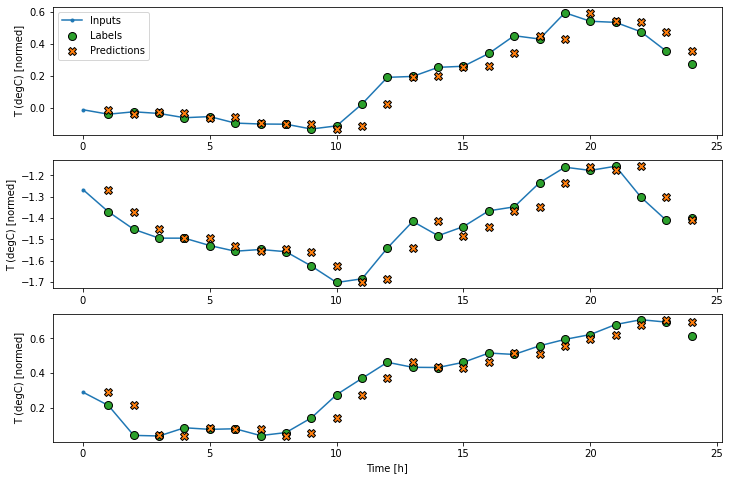

In [37]:
wide_window.plot(baseline)

### linear model

In [38]:
linear = tf.keras.Sequential([
    tf.keras.layers.Dense(units=1)
])

In [39]:
print('Input shape:', single_step_window.example[0].shape)
print('Output shape:', linear(single_step_window.example[0]).shape)

Input shape: (32, 1, 19)
Output shape: (32, 1, 1)


In [40]:
MAX_EPOCHS = 20

def compile_and_fit(model, window, patience=2):
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience, mode='min')

    model.compile(loss=tf.losses.MeanSquaredError(), optimizer=tf.optimizers.Adam(), metrics=[tf.metrics.MeanAbsoluteError()])

    history = model.fit(window.train, epochs=MAX_EPOCHS, validation_data=window.val, callbacks=[early_stopping])

    return history

In [41]:
history = compile_and_fit(linear, single_step_window)

val_performance['Linear'] = linear.evaluate(single_step_window.val)
performance['Linear'] = linear.evaluate(single_step_window.test, verbose=0)

Epoch 1/20
1534/1534 [==============================] - 5s 3ms/step - loss: 0.1074 - mean_absolute_error: 0.2015 - val_loss: 0.0140 - val_mean_absolute_error: 0.0886
Epoch 2/20
1534/1534 [==============================] - 5s 3ms/step - loss: 0.0122 - mean_absolute_error: 0.0828 - val_loss: 0.0107 - val_mean_absolute_error: 0.0776
Epoch 3/20
1534/1534 [==============================] - 4s 3ms/step - loss: 0.0102 - mean_absolute_error: 0.0747 - val_loss: 0.0093 - val_mean_absolute_error: 0.0716
Epoch 4/20
1534/1534 [==============================] - 4s 3ms/step - loss: 0.0095 - mean_absolute_error: 0.0716 - val_loss: 0.0091 - val_mean_absolute_error: 0.0710
Epoch 5/20
1534/1534 [==============================] - 4s 3ms/step - loss: 0.0094 - mean_absolute_error: 0.0710 - val_loss: 0.0089 - val_mean_absolute_error: 0.0698
Epoch 6/20
1534/1534 [==============================] - 5s 3ms/step - loss: 0.0093 - mean_absolute_error: 0.0707 - val_loss: 0.0089 - val_mean_absolute_error: 0.0701
Epoc

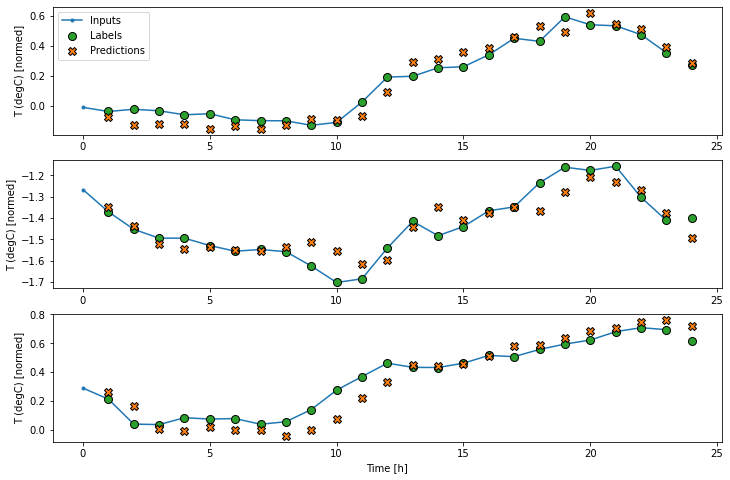

In [42]:
wide_window.plot(linear)

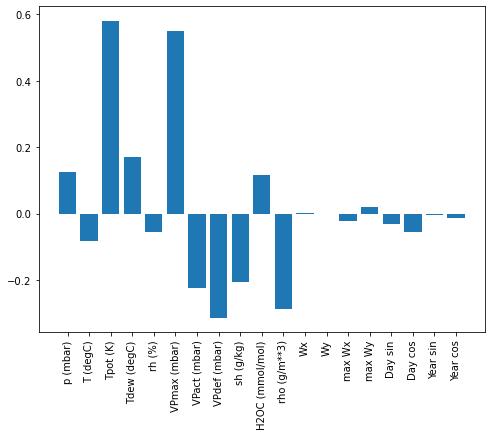

In [43]:
# check the weights assigned to each input
plt.bar(x = range(len(train_df.columns)),
        height=linear.layers[0].kernel[:,0].numpy())
axis = plt.gca()
axis.set_xticks(range(len(train_df.columns)))
_ = axis.set_xticklabels(train_df.columns, rotation=90)

### dense model

In [44]:
dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=1)
])

history = compile_and_fit(dense, single_step_window)

val_performance['Dense'] = dense.evaluate(single_step_window.val)
performance['Dense'] = dense.evaluate(single_step_window.test, verbose=0)

Epoch 1/20
1534/1534 [==============================] - 7s 4ms/step - loss: 0.0146 - mean_absolute_error: 0.0794 - val_loss: 0.0079 - val_mean_absolute_error: 0.0656
Epoch 2/20
1534/1534 [==============================] - 6s 4ms/step - loss: 0.0080 - mean_absolute_error: 0.0649 - val_loss: 0.0078 - val_mean_absolute_error: 0.0651
Epoch 3/20
1534/1534 [==============================] - 6s 4ms/step - loss: 0.0076 - mean_absolute_error: 0.0627 - val_loss: 0.0073 - val_mean_absolute_error: 0.0622
Epoch 4/20
1534/1534 [==============================] - 6s 4ms/step - loss: 0.0073 - mean_absolute_error: 0.0612 - val_loss: 0.0070 - val_mean_absolute_error: 0.0597
Epoch 5/20
1534/1534 [==============================] - 6s 4ms/step - loss: 0.0071 - mean_absolute_error: 0.0603 - val_loss: 0.0068 - val_mean_absolute_error: 0.0587
Epoch 6/20
1534/1534 [==============================] - 6s 4ms/step - loss: 0.0070 - mean_absolute_error: 0.0594 - val_loss: 0.0068 - val_mean_absolute_error: 0.0580
Epoc

### multi-step dense model

In [45]:
# give 3h of history, predict 1h into the future
CONV_WIDTH = 3
conv_window = WindowGenerator(input_width=CONV_WIDTH, label_width=1, shift=1, label_columns=['T (degC)'])
conv_window

Total window size: 4
Input indices: [0 1 2]
Label indices: [3]
Label column name(s): ['T (degC)']

Text(0.5, 1.0, 'give 3h of history, predict 1h into the future')

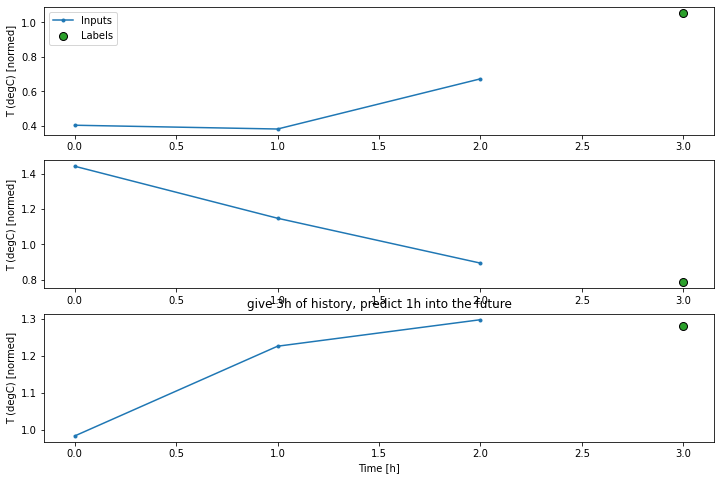

In [46]:
conv_window.plot()
plt.title('give 3h of history, predict 1h into the future')

In [47]:
multi_step_dense = tf.keras.Sequential([
    tf.keras.layers.Flatten(), # (time, features) -> (time*features)
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
    tf.keras.layers.Reshape([1, -1]) # add back the time dimension, (outputs) -> (1, outputs)
])

In [48]:
print('Input shape:', conv_window.example[0].shape)
print('Output shape:', multi_step_dense(conv_window.example[0]).shape)

Input shape: (32, 3, 19)
Output shape: (32, 1, 1)


In [49]:
history = compile_and_fit(multi_step_dense, conv_window)

IPython.display.clear_output()
val_performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.val)
performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.test, verbose=0)

438/438 [==============================] - 1s 2ms/step - loss: 0.0070 - mean_absolute_error: 0.0584


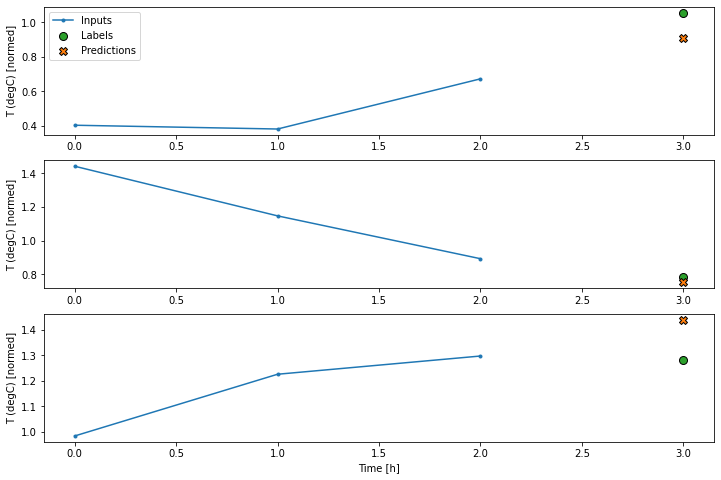

In [50]:
conv_window.plot(multi_step_dense)

In [51]:
# main problem of this approach is that the model can only be run on defined input windows
print('Input shape:', wide_window.example[0].shape)
try:
  print('Output shape:', multi_step_dense(wide_window.example[0]).shape)
except Exception as e:
  print(f'\n{type(e).__name__}:{e}')

Input shape: (32, 24, 19)

InvalidArgumentError:Matrix size-incompatible: In[0]: [32,456], In[1]: [57,32] [Op:MatMul]


### CNN

In [52]:
# CNN also takes multiple time steps as input, can be run on inputs of any length
conv_model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=32, kernel_size=(CONV_WIDTH, ), activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1)
])

In [53]:
print("Conv model on `conv_window`")
print('Input shape:', conv_window.example[0].shape)
print('Output shape:', conv_model(conv_window.example[0]).shape)

Conv model on `conv_window`
Input shape: (32, 3, 19)
Output shape: (32, 1, 1)


In [54]:
history = compile_and_fit(conv_model, conv_window)

IPython.display.clear_output()
val_performance['Conv'] = conv_model.evaluate(conv_window.val)
performance['Conv'] = conv_model.evaluate(conv_window.test, verbose=0)

438/438 [==============================] - 1s 3ms/step - loss: 0.0074 - mean_absolute_error: 0.0603


In [55]:
# if run on wider input, it will produce wider output
print("Wide window")
print('Input shape:', wide_window.example[0].shape)
print('Labels shape:', wide_window.example[1].shape)
print('Output shape:', conv_model(wide_window.example[0]).shape)

Wide window
Input shape: (32, 24, 19)
Labels shape: (32, 24, 1)
Output shape: (32, 22, 1)


In [56]:
LABEL_WIDTH = 24
INPUT_WIDTH = LABEL_WIDTH + (CONV_WIDTH - 1)  # add a few more inputs so that output length is same as label
wide_conv_window = WindowGenerator(input_width=INPUT_WIDTH, label_width=LABEL_WIDTH, shift=1, label_columns=['T (degC)'])

wide_conv_window

Total window size: 27
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25]
Label indices: [ 3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26]
Label column name(s): ['T (degC)']

In [57]:
print("Wide conv window")
print('Input shape:', wide_conv_window.example[0].shape)
print('Labels shape:', wide_conv_window.example[1].shape)
print('Output shape:', conv_model(wide_conv_window.example[0]).shape)

Wide conv window
Input shape: (32, 26, 19)
Labels shape: (32, 24, 1)
Output shape: (32, 24, 1)


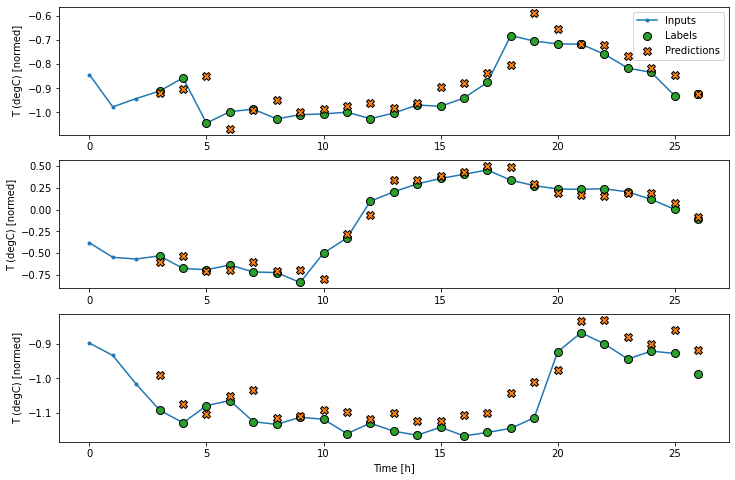

In [58]:
wide_conv_window.plot(conv_model)

### RNN

In [59]:
lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(32, return_sequences=True), # (batch, time, features) -> (batch, time, lstm_units)
    tf.keras.layers.Dense(units=1) # (batch, time, label)
])

In [60]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', lstm_model(wide_window.example[0]).shape)

Input shape: (32, 24, 19)
Output shape: (32, 24, 1)


In [61]:
history = compile_and_fit(lstm_model, wide_window)

IPython.display.clear_output()
val_performance['LSTM'] = lstm_model.evaluate(wide_window.val)
performance['LSTM'] = lstm_model.evaluate(wide_window.test, verbose=0)

438/438 [==============================] - 1s 3ms/step - loss: 0.0056 - mean_absolute_error: 0.0518


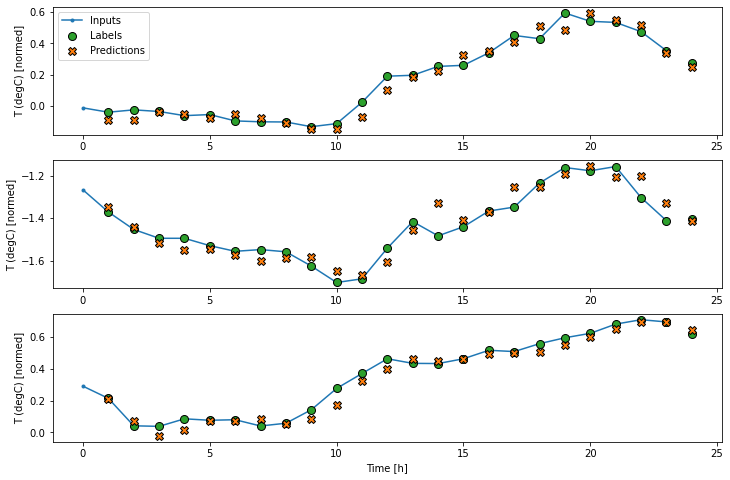

In [62]:
wide_window.plot(lstm_model)

### evaluate

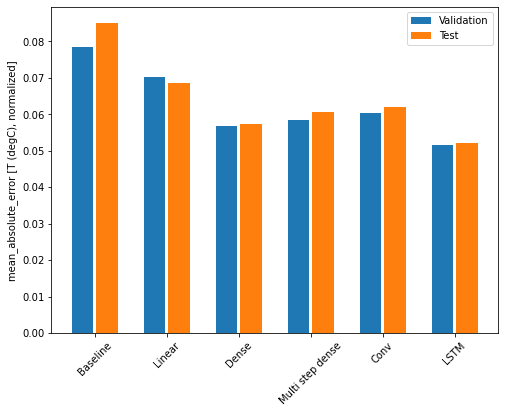

In [63]:
x = np.arange(len(performance))
width = 0.3
metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.ylabel('mean_absolute_error [T (degC), normalized]')
plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
_ = plt.legend()

In [64]:
for name, value in performance.items():
    print(f'{name:12s}: {value[1]:0.4f}')

Baseline    : 0.0852
Linear      : 0.0686
Dense       : 0.0575
Multi step dense: 0.0606
Conv        : 0.0620
LSTM        : 0.0523


### multi-output models

In [65]:
# previous models only predicted one feature, but can also predict all features
# by not setting the label_columns
single_step_window = WindowGenerator(input_width=1, label_width=1, shift=1)

wide_window = WindowGenerator(input_width=24, label_width=24, shift=1)

for example_inputs, example_labels in wide_window.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 24, 19)
Labels shape (batch, time, features): (32, 24, 19)


In [66]:
# baseline
baseline = Baseline()
baseline.compile(loss=tf.losses.MeanSquaredError(), metrics=[tf.metrics.MeanAbsoluteError()])

In [67]:
val_performance = {}
performance = {}

val_performance['Baseline'] = baseline.evaluate(wide_window.val)
performance['Baseline'] = baseline.evaluate(wide_window.test, verbose=0)

438/438 [==============================] - 1s 2ms/step - loss: 0.0886 - mean_absolute_error: 0.1589


In [68]:
# dense
dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=num_features)
])

In [69]:
history = compile_and_fit(dense, single_step_window)

IPython.display.clear_output()
val_performance['Dense'] = dense.evaluate(single_step_window.val)
performance['Dense'] = dense.evaluate(single_step_window.test, verbose=0)

439/439 [==============================] - 1s 3ms/step - loss: 0.0674 - mean_absolute_error: 0.1278


In [70]:
# rnn
lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(32, return_sequences=True),
    tf.keras.layers.Dense(units=num_features)
])

history = compile_and_fit(lstm_model, wide_window)

IPython.display.clear_output()
val_performance['LSTM'] = lstm_model.evaluate(wide_window.val)
performance['LSTM'] = lstm_model.evaluate(wide_window.test, verbose=0)

438/438 [==============================] - 1s 3ms/step - loss: 0.0620 - mean_absolute_error: 0.1204


### residual network

In [71]:
class ResidualWrapper(tf.keras.Model):
    def __init__(self, model):
        super().__init__()
        self.model = model

    def call(self, inputs, *args, **kwargs):
        delta = self.model(inputs, *args, **kwargs)

        # prediction for each timstep is input from previous timestep + delta as calculated by model
        return inputs + delta

In [72]:
residual_lstm = ResidualWrapper(
    tf.keras.Sequential([
        tf.keras.layers.LSTM(32, return_sequences=True),
        tf.keras.layers.Dense(num_features, kernel_initializer=tf.initializers.zeros) # predicted delta should start small, so init with zeros
    ])
)

history = compile_and_fit(residual_lstm, wide_window)

IPython.display.clear_output()
val_performance['Residual LSTM'] = residual_lstm.evaluate(wide_window.val)
performance['Residual LSTM'] = residual_lstm.evaluate(wide_window.test, verbose=0)

438/438 [==============================] - 1s 3ms/step - loss: 0.0621 - mean_absolute_error: 0.1181


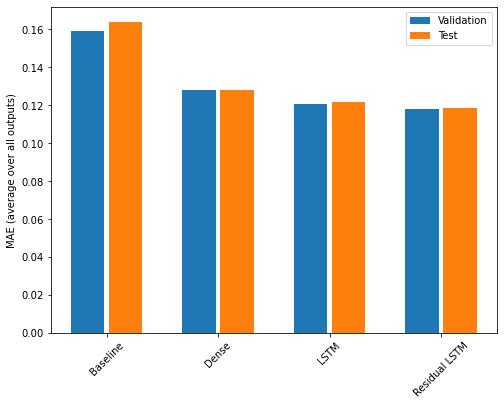

In [73]:
x = np.arange(len(performance))
width = 0.3

metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
plt.ylabel('MAE (average over all outputs)')
_ = plt.legend()

In [74]:
for name, value in performance.items():
  print(f'{name:15s}: {value[1]:0.4f}')

Baseline       : 0.1638
Dense          : 0.1282
LSTM           : 0.1215
Residual LSTM  : 0.1188


# Multi-step models

Total window size: 48
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47]
Label column name(s): None

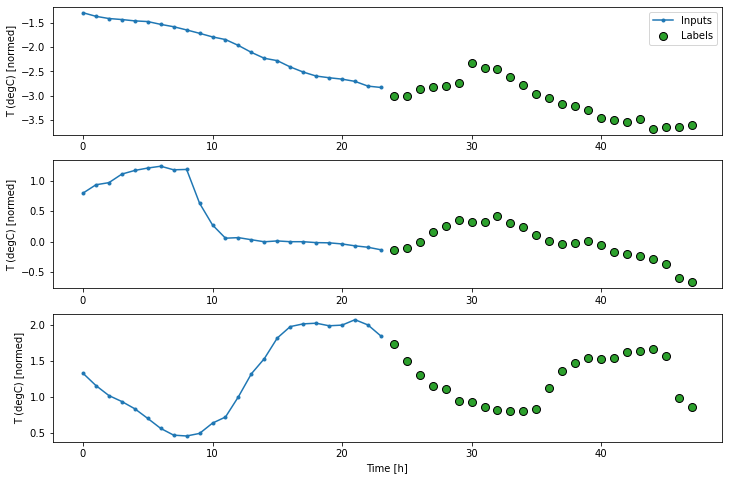

In [75]:
# given 24h of history, predict 24h of future
OUT_STEPS = 24
multi_window = WindowGenerator(input_width=24, label_width=OUT_STEPS, shift=OUT_STEPS)
multi_window.plot()
multi_window

### baseline

437/437 [==============================] - 1s 2ms/step - loss: 0.6285 - mean_absolute_error: 0.5007


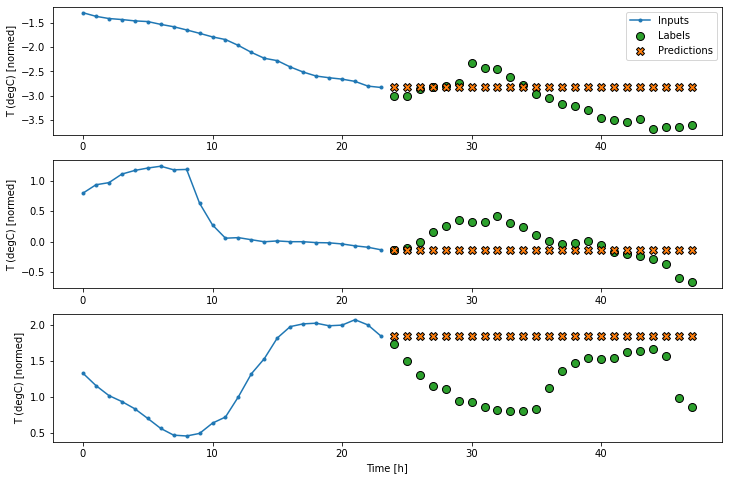

In [76]:
# one baseline just repeats last input as predictions
class MultiStepLastBaseline(tf.keras.Model):
    def call(self, inputs):
        return tf.tile(inputs[:, -1:, :], [1, OUT_STEPS, 1])

last_baseline = MultiStepLastBaseline()
last_baseline.compile(loss=tf.losses.MeanSquaredError(), metrics=[tf.metrics.MeanAbsoluteError()])

multi_val_performance = {}
multi_performance = {}

multi_val_performance['Last'] = last_baseline.evaluate(multi_window.val)
multi_performance['Last'] = last_baseline.evaluate(multi_window.test, verbose=0)
multi_window.plot(last_baseline)

437/437 [==============================] - 1s 2ms/step - loss: 0.4271 - mean_absolute_error: 0.3960


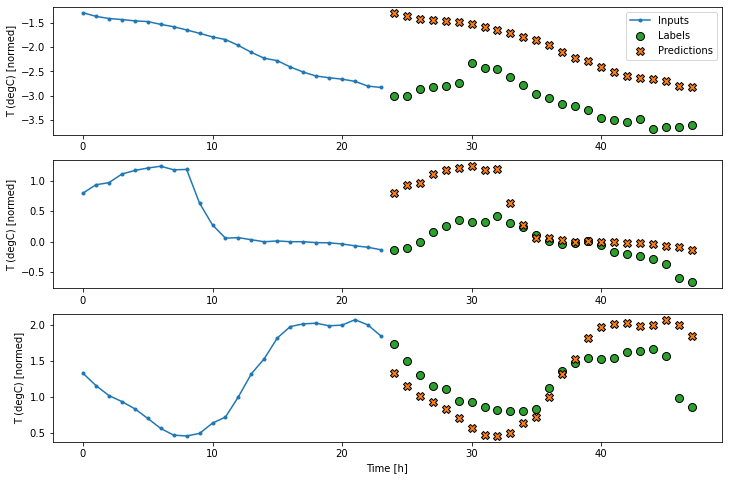

In [77]:
# another baseline just repeats last 24h
class RepeatBaseline(tf.keras.Model):
    def call(self, inputs):
        return inputs

repeat_baseline = RepeatBaseline()
repeat_baseline.compile(loss=tf.losses.MeanSquaredError(), metrics=[tf.metrics.MeanAbsoluteError()])

multi_val_performance['Repeat'] = repeat_baseline.evaluate(multi_window.val)
multi_performance['Repeat'] = repeat_baseline.evaluate(multi_window.test, verbose=0)
multi_window.plot(repeat_baseline)

### single-shot models

437/437 [==============================] - 1s 2ms/step - loss: 0.2555 - mean_absolute_error: 0.3056


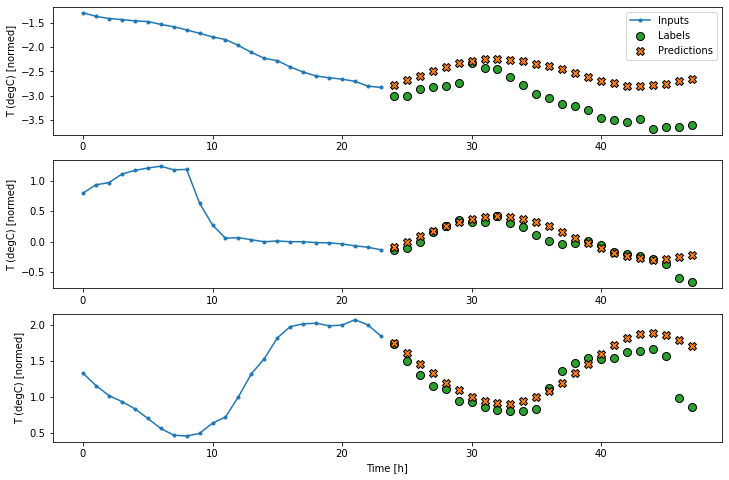

In [78]:
# linear, use the last timestep as a linear projection for predcitions
multi_linear_model = tf.keras.Sequential([
    # take the last timestep, (batch, time, features) -> (batch, 1, features)
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # predict all timesteps using last timestep, (batch, 1, out_steps * features)
    tf.keras.layers.Dense(OUT_STEPS * num_features, kernel_initializer=tf.initializers.zeros),
    # (batch, out_steps, features)
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_linear_model, multi_window)

IPython.display.clear_output()
multi_val_performance['Linear'] = multi_linear_model.evaluate(multi_window.val)
multi_performance['Linear'] = multi_linear_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_linear_model)

437/437 [==============================] - 1s 3ms/step - loss: 0.2203 - mean_absolute_error: 0.2830


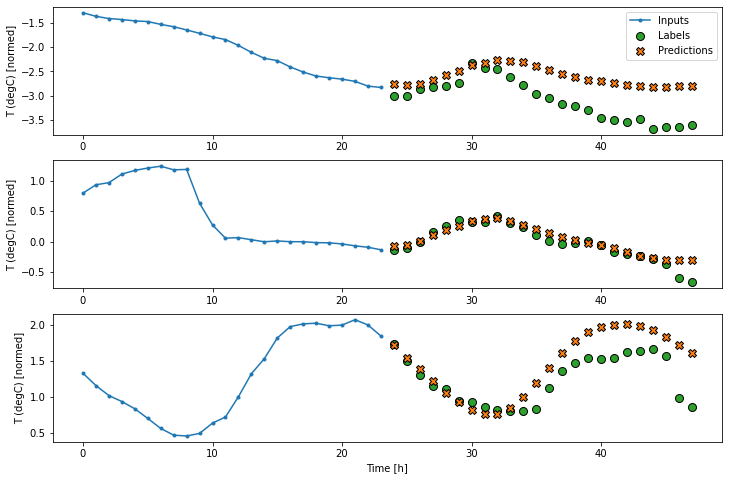

In [79]:
# dense
multi_dense_model = tf.keras.Sequential([
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(OUT_STEPS * num_features, kernel_initializer=tf.initializers.zeros),
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_dense_model, multi_window)

IPython.display.clear_output()
multi_val_performance['Dense'] = multi_dense_model.evaluate(multi_window.val)
multi_performance['Dense'] = multi_dense_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_dense_model)

437/437 [==============================] - 1s 2ms/step - loss: 0.2144 - mean_absolute_error: 0.2809


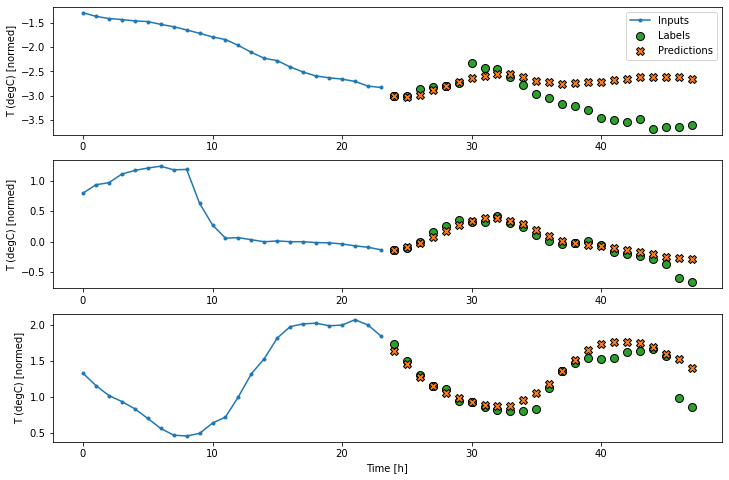

In [80]:
# CNN, which takes a conv window as input
CONV_WIDTH = 3
multi_conv_model = tf.keras.Sequential([
    tf.keras.layers.Lambda(lambda x: x[:, -CONV_WIDTH:, :]),
    tf.keras.layers.Conv1D(256, activation='relu', kernel_size=(CONV_WIDTH)),
    tf.keras.layers.Dense(OUT_STEPS * num_features, kernel_initializer=tf.initializers.zeros),
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_conv_model, multi_window)

IPython.display.clear_output()
multi_val_performance['Conv'] = multi_conv_model.evaluate(multi_window.val)
multi_performance['Conv'] = multi_conv_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_conv_model)

437/437 [==============================] - 1s 3ms/step - loss: 0.2161 - mean_absolute_error: 0.2882


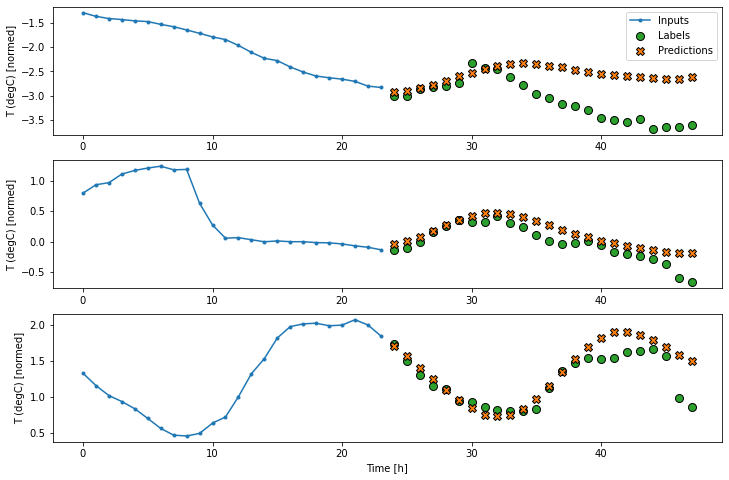

In [81]:
# rnn
multi_lstm_model = tf.keras.Sequential([
    tf.keras.layers.LSTM(32, return_sequences=False), # produce output at last timestep, so false
    tf.keras.layers.Dense(OUT_STEPS * num_features, kernel_initializer=tf.initializers.zeros),
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_lstm_model, multi_window)

IPython.display.clear_output()
multi_val_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.val)
multi_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_lstm_model)

### autoregressive model

In [82]:
class FeedBack(tf.keras.Model):
    def __init__(self, units, out_steps):
        super().__init__()
        self.out_steps = out_steps
        self.units = units
        self.lstm_cell = tf.keras.layers.LSTMCell(units)
        self.lstm_rnn = tf.keras.layers.RNN(self.lstm_cell, return_state=True)
        self.dense = tf.keras.layers.Dense(num_features)

In [83]:
feedback_model = FeedBack(units=32, out_steps=OUT_STEPS)

In [84]:
# method to initialize state based on inputs
def warmup(self, inputs):
    x, *state = self.lstm_rnn(inputs)
    prediction = self.dense(x)
    return prediction, state

FeedBack.warmup = warmup

In [85]:
prediction, state = feedback_model.warmup(multi_window.example[0])
prediction.shape

TensorShape([32, 19])

In [86]:
def call(self, inputs, training=None):
    # use TensorArray to keep dynamically unrolled outputs
    predictions = []

    # init lstm state
    prediction, state = self.warmup(inputs)

    # first prediction
    predictions.append(prediction)

    # run rest of prediction steps
    for n in range(1, self.out_steps):
        # use last prediction as input
        x = prediction
        # one lstm step
        x, state = self.lstm_cell(x, states=state, training=training)
        # convert lstm output to prediction
        prediction = self.dense(x)
        predictions.append(prediction)

    predictions = tf.stack(predictions) # (time, batch, features)
    predictions = tf.transpose(predictions, [1, 0, 2]) # (batch, time, features)
    return predictions

FeedBack.call = call

In [87]:
print('Output shape (batch, time, features): ', feedback_model(multi_window.example[0]).shape)

Output shape (batch, time, features):  (32, 24, 19)


437/437 [==============================] - 4s 10ms/step - loss: 0.2276 - mean_absolute_error: 0.3003


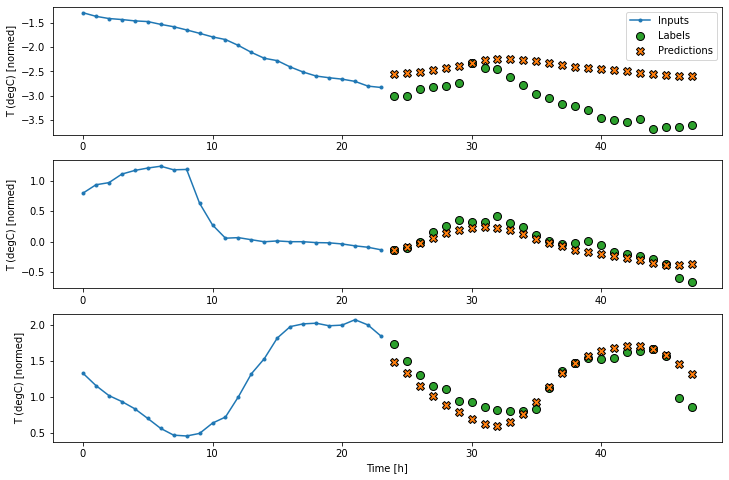

In [88]:
history = compile_and_fit(feedback_model, multi_window)

IPython.display.clear_output()
multi_val_performance['AR LSTM'] = feedback_model.evaluate(multi_window.val)
multi_performance['AR LSTM'] = feedback_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(feedback_model)

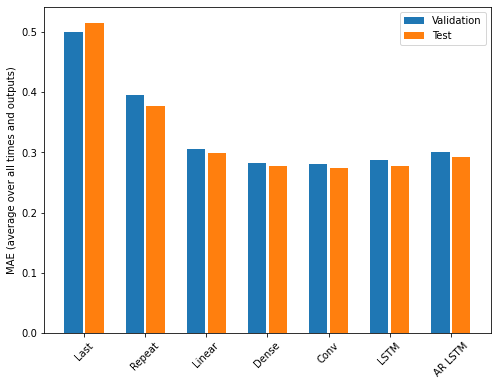

In [89]:
x = np.arange(len(multi_performance))
width = 0.3


metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in multi_val_performance.values()]
test_mae = [v[metric_index] for v in multi_performance.values()]

plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=multi_performance.keys(),
           rotation=45)
plt.ylabel(f'MAE (average over all times and outputs)')
_ = plt.legend()

In [90]:
for name, value in multi_performance.items():
  print(f'{name:8s}: {value[1]:0.4f}')

Last    : 0.5157
Repeat  : 0.3775
Linear  : 0.2985
Dense   : 0.2770
Conv    : 0.2738
LSTM    : 0.2782
AR LSTM : 0.2919
